In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np

# 모델 선택 및 평가 관련 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# 전처리: 범주형 인코딩, 결측치 대체, 스케일링
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 데이터 로드
train = pd.read_csv('/content/drive/MyDrive/open/train.csv').drop(columns=['ID'])
test = pd.read_csv('/content/drive/MyDrive/open/test.csv').drop(columns=['ID'])


In [7]:

# 제거할 피처 리스트
features_to_remove = [
    "불임 원인 - 자궁경부 문제",
    "불임 원인 - 자궁내막증",
    "불임 원인 - 정자 농도",
    "불임 원인 - 정자 면역학적 요인",
    "불임 원인 - 정자 운동성",
    "불임 원인 - 정자 형태",
    "PGD 시술 여부",
    "PGS 시술 여부",
    "난자 채취 경과일",
    "난자 해동 경과일",
    "배아 생성 주요 이유"
]

# 해당 피처들 제거
train = train.drop(columns=features_to_remove, errors='ignore')
test = test.drop(columns=features_to_remove, errors='ignore')

# 타겟(입신 성공 여부) 분리 + 결측치 제거
y = train['임신 성공 여부']  # 타겟 변수 분리
x = train.drop(columns=['임신 성공 여부'])  # 입력 변수(x) 정의

# x에서 y의 결측치가 있는 행 제거
x = x.loc[y.dropna().index]
y = y.dropna()  # y에서도 결측치 제거

# 범주형 컬럼 전체 정의 (제거한 피처 제외)
categorical_columns = [
    "시술 시기 코드",
    "시술 당시 나이",
    "시술 유형",
    "특정 시술 유형",
    "배란 자극 여부",
    "배란 유도 유형",
    "단일 배아 이식 여부",
    "착상 전 유전 검사 사용 여부",
    "착상 전 유전 진단 사용 여부",
    "남성 주 불임 원인",
    "남성 부 불임 원인",
    "여성 주 불임 원인",
    "여성 부 불임 원인",
    "부부 주 불임 원인",
    "부부 부 불임 원인",
    "불명확 불임 원인",
    "불임 원인 - 난관 질환",
    "불임 원인 - 남성 요인",
    "불임 원인 - 배란 장애",
    "불임 원인 - 여성 요인",
    "총 시술 횟수",
    "클리닉 내 총 시술 횟수",
    "IVF 시술 횟수",
    "DI 시술 횟수",
    "총 임신 횟수",
    "IVF 임신 횟수",
    "DI 임신 횟수",
    "총 출산 횟수",
    "IVF 출산 횟수",
    "DI 출산 횟수",
    "난자 출처",
    "정자 출처",
    "난자 기증자 나이",
    "정자 기증자 나이",
    "동결 배아 사용 여부",
    "신선 배아 사용 여부",
    "기증 배아 사용 여부",
    "대리모 여부"
]

# 범주형 컬럼을 문자열(str)로 변환
for col in categorical_columns:
    if col in x.columns:  # 컬럼이 존재하는지 확인
        x.loc[:, col] = x[col].astype(str)
        test.loc[:, col] = test[col].astype(str)

# 수치형 컬럼 전체 정의
numeric_columns = [
    "임신 시도 또는 마지막 임신 경과 연수",
    "총 생성 배아 수",
    "미세주입된 난자 수",
    "미세주입에서 생성된 배아 수",
    "이식된 배아 수",
    "미세주입 배아 이식 수",
    "저장된 배아 수",
    "미세주입 후 저장된 배아 수",
    "해동된 배아 수",
    "해동 난자 수",
    "수집된 신선 난자 수",
    "저장된 신선 난자 수",
    "혼합된 난자 수",
    "파트너 정자와 혼합된 난자 수",
    "기증자 정자와 혼합된 난자 수",
    "난자 혼합 경과일",
    "배아 이식 경과일",
    "배아 해동 경과일"
]

# train 데이터를 train/val로 분할
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# 범주형 변수 인코딩
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
x_train_enc = x_train.copy()
x_train_enc[categorical_columns] = ordinal_encoder.fit_transform(x_train_enc[categorical_columns])

x_val_enc = x_val.copy()
x_val_enc[categorical_columns] = ordinal_encoder.transform(x_val_enc[categorical_columns])
from sklearn.impute import SimpleImputer

# 범주형 변수 결측치를 최빈값으로 대체
cat_imputer = SimpleImputer(strategy='most_frequent')
x_train_enc[categorical_columns] = cat_imputer.fit_transform(x_train_enc[categorical_columns])
x_val_enc[categorical_columns] = cat_imputer.transform(x_val_enc[categorical_columns])
# 수치형 변수 결측치 대체 (중앙값 사용)
imputer = SimpleImputer(strategy='median')
x_train_enc[numeric_columns] = imputer.fit_transform(x_train_enc[numeric_columns])
x_val_enc[numeric_columns] = imputer.transform(x_val_enc[numeric_columns])

# catboost 패키지 설치


<ipython-input-7-0a1b1ac4a77e>:73: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '0' '1' ... '1' '1' '0']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x.loc[:, col] = x[col].astype(str)
<ipython-input-7-0a1b1ac4a77e>:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '1' '1' ... '0' '0' '1']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test.loc[:, col] = test[col].astype(str)
<ipython-input-7-0a1b1ac4a77e>:73: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0.0' '0.0' '0.0' ... '0.0' '0.0' '0.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  x.loc[:, col] = x[col].astype(str)
<ipython-input-7-0a1b1ac4a77e>:74: FutureWarning: Settin

In [4]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier, Pool

# 결측치 처리 - 범주형/수치형 변수 각각 처리
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='median')

# 범주형 변수 결측치 처리
x_cat = x[categorical_columns].copy()
x_cat = pd.DataFrame(cat_imputer.fit_transform(x_cat), columns=categorical_columns, index=x.index)

# 수치형 변수 결측치 처리
x_num = x[numeric_columns].copy()
x_num = pd.DataFrame(num_imputer.fit_transform(x_num), columns=numeric_columns, index=x.index)

# 처리된 데이터 합치기
x_processed = pd.concat([x_cat, x_num], axis=1)

# 클래스 불균형 비율 계산
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
print(f"Calculated scale_pos_weight: {scale_pos_weight}")

# 교차 검증 설정
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 예측 결과를 저장할 배열 초기화
test_predictions = np.zeros(len(test))
oof_predictions = np.zeros(len(x_processed))
cv_scores = []

# 테스트 데이터 전처리
test_cat = test[categorical_columns].copy()
test_cat = pd.DataFrame(cat_imputer.transform(test_cat), columns=categorical_columns, index=test.index)

test_num = test[numeric_columns].copy()
test_num = pd.DataFrame(num_imputer.transform(test_num), columns=numeric_columns, index=test.index)

test_processed = pd.concat([test_cat, test_num], axis=1)

# 하이퍼파라미터 직접 설정 (몇 가지 설정을 시도)
params_list = [
    {
        'iterations': 1000,
        'learning_rate': 0.03,
        'depth': 8,
        'l2_leaf_reg': 3,
        'random_strength': 1,
        'bagging_temperature': 1,
        'grow_policy': 'SymmetricTree'
    },
    {
        'iterations': 1500,
        'learning_rate': 0.02,
        'depth': 7,
        'l2_leaf_reg': 5,
        'random_strength': 0.8,
        'bagging_temperature': 0.5,
        'grow_policy': 'Depthwise'
    },
    {
        'iterations': 2000,
        'learning_rate': 0.01,
        'depth': 10,
        'l2_leaf_reg': 1,
        'random_strength': 0.1,
        'bagging_temperature': 0,
        'grow_policy': 'Lossguide'
    }
]

# 각 하이퍼파라미터 세트에 대한 성능을 저장
params_cv_scores = []

for param_idx, params in enumerate(params_list):
    print(f"\nTesting hyperparameter set {param_idx + 1}/{len(params_list)}")
    fold_cv_scores = []

    # 각 fold에 대한 학습 및 예측
    for fold, (train_idx, val_idx) in enumerate(kf.split(x_processed, y)):
        print(f"Training fold {fold + 1}/5")

        # 훈련/검증 데이터 분할
        X_train = x_processed.iloc[train_idx].reset_index(drop=True)
        y_train = y.iloc[train_idx].reset_index(drop=True)
        X_val = x_processed.iloc[val_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)

        # 모델 설정
        model = CatBoostClassifier(
            **params,
            loss_function='Logloss',
            eval_metric='AUC',
            cat_features=categorical_columns,  # 범주형 변수 이름으로 지정
            scale_pos_weight=scale_pos_weight,
            verbose=50,  # 로그 빈도 줄임
            random_seed=42 + fold
        )

        # Pool 객체로 데이터 래핑 (범주형 변수 이름으로 지정)
        train_pool = Pool(
            data=X_train,
            label=y_train,
            cat_features=categorical_columns
        )

        val_pool = Pool(
            data=X_val,
            label=y_val,
            cat_features=categorical_columns
        )

        # 모델 학습
        model.fit(
            train_pool,
            eval_set=val_pool,
            early_stopping_rounds=50,
            verbose=50
        )

        # 검증 세트 예측
        val_preds = model.predict_proba(X_val)[:, 1]
        oof_predictions[val_idx] = val_preds

        # 검증 세트 성능 평가
        fold_score = roc_auc_score(y_val, val_preds)
        fold_cv_scores.append(fold_score)
        print(f"Fold {fold + 1} ROC AUC: {fold_score:.6f}")

        # 테스트 데이터 예측 (앙상블용)
        test_pool = Pool(
            data=test_processed,
            cat_features=categorical_columns
        )

        test_predictions += model.predict_proba(test_pool)[:, 1] / (len(params_list) * kf.n_splits)

    # 현재 하이퍼파라미터의 평균 성능 계산
    mean_fold_score = np.mean(fold_cv_scores)
    params_cv_scores.append(mean_fold_score)
    print(f"Mean CV score for parameter set {param_idx + 1}: {mean_fold_score:.6f}")

    # 각 파라미터 세트별 예측 결과를 CSV로 저장
    param_submission = pd.read_csv('/content/drive/MyDrive/open/sample_submission.csv')
    param_submission['probability'] = test_predictions * (len(params_list) * kf.n_splits) / ((param_idx + 1) * kf.n_splits)
    param_submission.to_csv(f'./catboost_param_set_{param_idx + 1}_submission.csv', index=False)
    print(f"Parameter set {param_idx + 1} predictions saved to catboost_param_set_{param_idx + 1}_submission.csv")


Calculated scale_pos_weight: 2.870734432566286

Testing hyperparameter set 1/3
Training fold 1/5
0:	test: 0.7207212	best: 0.7207212 (0)	total: 1.48s	remaining: 24m 41s
50:	test: 0.7331216	best: 0.7331216 (50)	total: 1m	remaining: 18m 51s
100:	test: 0.7356124	best: 0.7356124 (100)	total: 2m 6s	remaining: 18m 42s
150:	test: 0.7366432	best: 0.7366432 (150)	total: 3m 7s	remaining: 17m 32s
200:	test: 0.7371387	best: 0.7371387 (200)	total: 4m 4s	remaining: 16m 13s
250:	test: 0.7374207	best: 0.7374207 (250)	total: 5m 4s	remaining: 15m 7s
300:	test: 0.7376513	best: 0.7376513 (300)	total: 6m 1s	remaining: 13m 58s
350:	test: 0.7378263	best: 0.7378263 (350)	total: 6m 59s	remaining: 12m 56s
400:	test: 0.7379645	best: 0.7379645 (400)	total: 8m 2s	remaining: 12m
450:	test: 0.7380891	best: 0.7380947 (448)	total: 9m 6s	remaining: 11m 5s
500:	test: 0.7382018	best: 0.7382195 (484)	total: 10m 14s	remaining: 10m 12s
550:	test: 0.7382921	best: 0.7382921 (550)	total: 11m 19s	remaining: 9m 13s
600:	test: 0.7

In [9]:

# 최고 성능 하이퍼파라미터 출력
best_param_idx = np.argmax(params_cv_scores)
print(f"\nBest hyperparameter set ({best_param_idx + 1}): {params_list[best_param_idx]}")
print(f"Best mean CV score: {params_cv_scores[best_param_idx]:.6f}")

# OOF (Out-of-fold) 예측의 성능 평가
oof_score = roc_auc_score(y, oof_predictions)
print(f"Overall OOF ROC AUC: {oof_score:.6f}")

# 최종 앙상블 예측 결과를 CSV로 저장
ensemble_submission = pd.read_csv('/content/drive/MyDrive/open/sample_submission.csv')
ensemble_submission['probability'] = test_predictions
ensemble_submission.to_csv('./catboost_ensemble_submission.csv', index=False)
print("Ensemble predictions saved to catboost_ensemble_submission.csv")



Best hyperparameter set (1): {'iterations': 1000, 'learning_rate': 0.03, 'depth': 8, 'l2_leaf_reg': 3, 'random_strength': 1, 'bagging_temperature': 1, 'grow_policy': 'SymmetricTree'}
Best mean CV score: 0.739862
Overall OOF ROC AUC: 0.739034
Ensemble predictions saved to catboost_ensemble_submission.csv


In [10]:

# 피처 중요도 분석을 위한 최종 모델 훈련
print("\nTraining final model for feature importance analysis...")
final_model = CatBoostClassifier(
    **params_list[best_param_idx],
    loss_function='Logloss',
    eval_metric='AUC',
    cat_features=categorical_columns,
    scale_pos_weight=scale_pos_weight,
    verbose=100,
    random_seed=42
)

final_pool = Pool(
    data=x_processed,
    label=y,
    cat_features=categorical_columns
)

final_model.fit(final_pool)



Training final model for feature importance analysis...
0:	total: 1.35s	remaining: 22m 26s
100:	total: 2m 22s	remaining: 21m 4s
200:	total: 4m 38s	remaining: 18m 26s
300:	total: 6m 54s	remaining: 16m 2s
400:	total: 9m 5s	remaining: 13m 34s
500:	total: 11m 32s	remaining: 11m 30s
600:	total: 14m 3s	remaining: 9m 20s
700:	total: 16m 32s	remaining: 7m 3s
800:	total: 19m 3s	remaining: 4m 44s
900:	total: 21m 30s	remaining: 2m 21s
999:	total: 24m	remaining: 0us


In [11]:

# 최종 모델의 예측 결과를 CSV로 저장
final_test_pool = Pool(
    data=test_processed,
    cat_features=categorical_columns
)
final_predictions = final_model.predict_proba(final_test_pool)[:, 1]

final_submission = pd.read_csv('/content/drive/MyDrive/open/sample_submission.csv')
final_submission['probability'] = final_predictions
final_submission.to_csv('./catboost_final_model_submission.csv', index=False)
print("Final model predictions saved to catboost_final_model_submission.csv")

# 피처 중요도 계산 및 시각화
feature_importance = final_model.get_feature_importance(final_pool)
importance_df = pd.DataFrame({
    'Feature': x_processed.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\nTop 20 important features:")
print(importance_df.head(20))


Final model predictions saved to catboost_final_model_submission.csv

Top 20 important features:
            Feature  Importance
42         이식된 배아 수   70.258089
1          시술 당시 나이    5.957161
54        배아 이식 경과일    3.255656
44         저장된 배아 수    2.933360
39        총 생성 배아 수    2.144885
48      수집된 신선 난자 수    1.436905
30            난자 출처    1.248243
0          시술 시기 코드    0.761114
21    클리닉 내 총 시술 횟수    0.727262
22        IVF 시술 횟수    0.719884
6       단일 배아 이식 여부    0.708394
24          총 임신 횟수    0.688517
28        IVF 출산 횟수    0.656076
3          특정 시술 유형    0.575309
50         혼합된 난자 수    0.525543
20          총 시술 횟수    0.504572
41  미세주입에서 생성된 배아 수    0.500300
43     미세주입 배아 이식 수    0.406208
17    불임 원인 - 남성 요인    0.382917
40       미세주입된 난자 수    0.360380


<ipython-input-12-1c5186d0f220>:8: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-1c5186d0f220>:8: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-1c5186d0f220>:8: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-1c5186d0f220>:8: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-1c5186d0f220>:8: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-1c5186d0f220>:8: UserWarning: Glyph 45212 (\N{HANGUL SYLLABLE NAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-1c5186d0f220>:8: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12

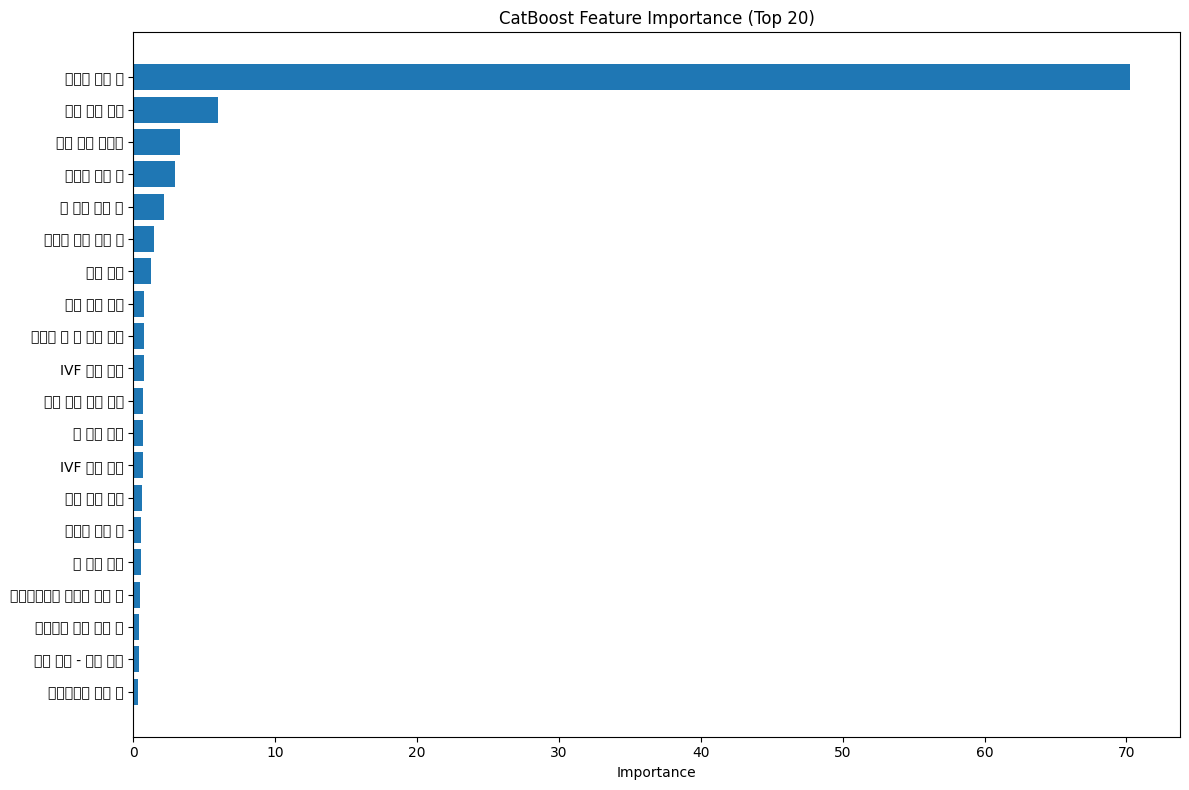

Feature importance saved to feature_importance.xlsx


In [12]:

# 중요도 그래프 (선택적)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'].head(20)[::-1], importance_df['Importance'].head(20)[::-1])
plt.xlabel('Importance')
plt.title('CatBoost Feature Importance (Top 20)')
plt.tight_layout()
plt.savefig('feature_importance_plot.png')
plt.show()

# 중요도 엑셀 파일로 저장
importance_df.to_excel('feature_importance.xlsx', index=False)
print("Feature importance saved to feature_importance.xlsx")


In [13]:

# OOF 예측 결과도 저장
oof_df = pd.DataFrame({
    'actual': y,
    'predicted': oof_predictions
})
oof_df.to_csv('./catboost_oof_predictions.csv', index=False)
print("OOF predictions saved to catboost_oof_predictions.csv")

OOF predictions saved to catboost_oof_predictions.csv
